In [3]:
import numpy as np
import pandas as pd
from datetime import date
import xarray as xr

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import regionmask
from sklearn.model_selection import GridSearchCV

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important;}</style>"))

In [4]:
def get_data():
    # Daily nino34 data 
    mydateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")
    nino=pd.read_csv("http://climexp.knmi.nl/data/inino34_daily.dat",
                    delim_whitespace=True, skiprows=12,
                    names=['date','value'],
                    parse_dates=['date'], date_parser=mydateparser
                    )
    nino = nino.set_index('date')
    nino['enso']=nino['value'].rolling(7,center=True).mean()
    x1nino=nino.loc['1980-12-01':'2016-02-28']
    
    # weekly DMI data 
    f2 = xr.open_dataset('/Users/dongxiay/Documents/data/dmi.nc')
    x2dmi=f2['DMI'].sel(WEDCEN2=slice('1980-12-01T00:00:00.000000000','2016-02-28T00:00:00.000000000')).to_dataframe()

#     # Daily MJO
    dt = pd.read_csv("http://passage.phys.ocean.dal.ca/~olivere/data/mjoindex_IHR_20CRV2c.dat")
    dt['date'] = pd.to_datetime(dt[["year", "month", "day"]])
    dt = dt.set_index('date')
    dt.loc[dt['amplitude'].lt(1) ,'phase'] = 0
    mjo=dt[['IHR1','IHR2']].loc['1980-12-01':'2016-02-28']
    
    # railfall
    frain = xr.open_mfdataset('//Users/dongxiay/Documents/data/daily/*.nc', parallel=True)
    rain_au=frain['apcp'].loc[:,-30:0,110:160].coarsen(lat=2, boundary="trim",lon=2).mean().load()
        # rollmean
        #rain_au.rolling(time=7,center=True).mean().loc['1981-12-01':'2015-02-28']
        # normalization
    climatology_mean = rain_au.groupby("time.month").mean("time")
    climatology_std = rain_au.groupby("time.month").std("time")
    stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
        rain_au.groupby("time.month"),
        climatology_mean,
        climatology_std,
        input_core_dims=[["time","lat","lon"], ["lat","lon"], ["lat","lon"]],
        output_core_dims=[["time","lat","lon"]],
    )
         # mask aus   
    mask = regionmask.defined_regions.natural_earth.countries_110.mask(stand_anomalies)
    AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
    tropical_AU = stand_anomalies.where(mask == AU_index)
    
    return x2dmi, x1nino, tropical_AU.load(), mjo

    

In [5]:

def get_one_grid_ts(x2dmi, x1nino, tropical_AU, mjo, lat, lon):
    
    rain_ts=tropical_AU.loc[:,lat,lon].to_dataframe()

    # merge together
    data=x2dmi.merge(x1nino['enso'],left_index=True, right_index=True,  how='inner')\
    .merge(rain_ts['apcp'],left_index=True, right_index=True,  how='inner')\
    .merge(mjo,left_index=True, right_index=True,  how='inner')
    data=data.rolling(4,center=True).mean()
    return data
    

In [6]:
def create_lead_lag_features(df_, cols, steps):
    df = df_.copy()
    for col in cols:
        for stp in steps:
            df[f"{col}_{stp}"] = df[col].shift(stp)
    return df

def feature_engineering(df_):
    df = df_.copy()
    
    # add month 
    df['month'] = df.index.month
    
    # add lagging 
    df = create_lead_lag_features(df, ['IHR1','IHR2'], np.arange(1,5,1))
    df = create_lead_lag_features(df, ['enso','DMI'], np.arange(4,56,4))
#     df = create_lead_lag_features(df, ['enso','DMI','IHR1','IHR2'], np.arange(4,56,4))
    # add week
    #df['week'] = df.index.week
    
    # keep DJF only
#     df = df[df.index.month.isin([12,1,2])]

    # remove no rainfall periods
    #df = df[df['apcp']>0.05]
    
    # remove NaN
    df = df.dropna()
    
    return df

In [7]:
def split_data(df, config):
    # add features
    data2 = feature_engineering(data)
    target_val = 'apcp'
    
    if 'selected_features' in config.keys() and config['selected_features'] is not None:
        data2 = data2[config['selected_features']+[target_val]]

    # split data into train, test and eval
    
    X = data2[[x for x in data2.columns if x != target_val]]
    y = data2[target_val]
    ## get eval based on time
    X_eval = X.loc[config['val_start_date']:]
    y_eval = y.loc[config['val_start_date']:]
    ## get train, test randomly
    X_train, X_test, y_train, y_test = train_test_split(
        X.loc[:config['val_start_date']], 
        y.loc[:config['val_start_date']], 
        test_size=config['test_size'], 
        random_state=config['random_state']
    )
    return X_train, y_train, X_test, y_test, X_eval, y_eval
    

def create_pipeline(df, config):
    # create model pipeline
    pipeline = Pipeline([
        ('standard', StandardScaler()),
        ('model', xgb.XGBRegressor(**config['model_params']))
    ])
    return pipeline

def run_once(df, config):
    X_train, y_train, X_test, y_test, X_eval, y_eval = split_data(df, config)
    pipeline = create_pipeline(df, config)
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    
    # rmse
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    # feature importance
    fimp = pd.DataFrame({
        'importance': pipeline.steps[-1][1].feature_importances_
    }, index=X_train.columns)
    
    df_test = pd.DataFrame({
    'y':y_test,
    'y_':preds
})
    df_eval = pd.DataFrame({
    'y':y_eval,
    'y_':pipeline.predict(X_eval)
})
    
    return rmse, fimp, df_test, df_eval

def run_with_gridsearchcv(df, config):
    X_train, y_train, X_test, y_test, X_eval, y_eval = split_data(df, config)
    pipeline = create_pipeline(df, config)

    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    hyperparameters = { 
#         'model__min_child_weight': [1, 5, 10],
#         'model__gamma': [0.5, 1, 1.5, 2, 5],
#         'model__subsample': [0.6, 0.8, 1.0],
#         'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__max_depth': [3, 4, 5, 8, 10]
    }
    clf = GridSearchCV(pipeline, hyperparameters, cv=5)

    # run param grid search
    clf.fit(X_train, y_train)

    # best param found
    best_params = clf.best_params_

    # retrain with best param
    clf.refit
    preds = clf.predict(X_test)
    
    # rmse
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    # feature importance
    fimp = pd.DataFrame({
        'importance': pipeline.steps[-1][1].feature_importances_
    }, index=X_train.columns)
    
    return rmse, fimp, best_params

# get data

In [8]:
x2dmi, x1nino, tropical_AU, mjo = get_data()

/var/folders/hk/5g956sdx0n16qr5wzr0n673c0000gp/T/ipykernel_20507/2109425791.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  mydateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")


# test one grid point

In [9]:
lat, lon = -19.5, 144.5
data = get_one_grid_ts(x2dmi, x1nino, tropical_AU, mjo, lat, lon)
data

,DMI,enso,apcp,IHR1,IHR2
1981-11-04,NaN,NaN,NaN,NaN,NaN
1981-11-11,NaN,NaN,NaN,NaN,NaN
1981-11-18,-0.276452,-0.486080,1.143462,0.294111,0.226339
1981-11-25,-0.288649,-0.288734,1.198358,0.313421,-0.054568
1981-12-02,-0.175542,-0.205299,1.221760,0.699190,0.477167
...,...,...,...,...,...
2014-12-03,-0.037669,0.931215,-0.205890,0.216670,0.116530
2014-12-10,-0.195798,0.866189,-0.141693,0.063980,0.113737
2014-12-17,-0.341515,0.771764,-0.184310,-0.058060,-0.000763
2014-12-24,-0.489387,0.636742,0.071477,-0.126630,-0.161748


test rmse:  0.3312467925355704
importance    0.107212
Name: enso_16, dtype: float32


<AxesSubplot:>

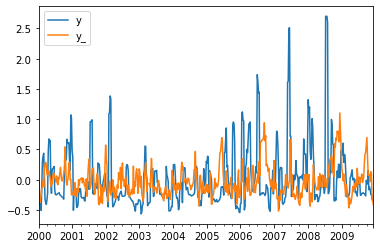

In [91]:
lat, lon = -19.5, 144.5
data = get_one_grid_ts(x2dmi, x1nino, tropical_AU, mjo, lat, lon)

config = {
    'val_start_date': '2000-01-01',
    'test_size': 0.2,
    'random_state': 123,
    'model_params':{
        #'max_depth':4
    }
}
rsl = run_once(data, config)
rmse = rsl[0]
fimp = rsl[1]
df_test =rsl[2]
df_eval = rsl[3]
print('test rmse: ',rmse)
print(fimp.loc[fimp['importance'].idxmax()])
df_eval.iloc[:520].plot()

<AxesSubplot:>

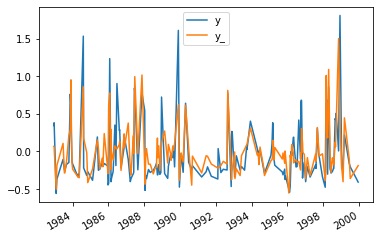

In [113]:
df_test.iloc[:520].plot()

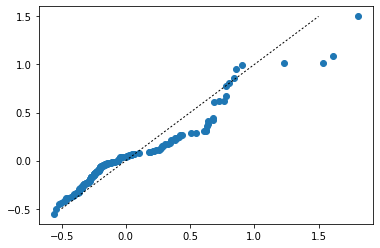

In [119]:
import numbers

import numpy as np
import matplotlib.pyplot as plt


def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.plot([-0.5,1.5], [-0.5, 1.5], 'k-', lw=1,dashes=[2, 2])

qqplot(df_test['y'],df_test['y_'])

In [101]:
fimp_df = pd.DataFrame()

for i in range(10):
    config = {
    'val_start_date': '2000-01-01',
    'test_size': 0.2,
    'random_state': i,
    'model_params':{
        #'max_depth':4
    }
    }
    rsl = run_once(data, config)
    fimp = rsl[1]
    fimp_df=fimp_df.merge(fimp.sort_values("importance",ascending=False).iloc[:10].rename(columns={"importance":f"importance_{i}"}), right_index=True, left_index=True, how='outer')
fimp_df

,importance_0,importance_1,importance_2,importance_3,importance_4,importance_5,importance_6,importance_7,importance_8,importance_9
DMI_12,NaN,NaN,NaN,0.040355,0.040203,0.043837,0.040932,NaN,NaN,NaN
DMI_16,0.040504,NaN,NaN,NaN,NaN,NaN,NaN,0.026811,NaN,NaN
DMI_20,NaN,NaN,NaN,NaN,NaN,NaN,0.033800,NaN,NaN,NaN
DMI_24,NaN,NaN,NaN,NaN,NaN,NaN,0.037880,NaN,0.040217,NaN
DMI_32,NaN,NaN,0.038609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DMI_4,0.095053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DMI_44,0.034844,0.079812,0.051861,NaN,0.042903,0.050989,0.035776,NaN,0.051702,NaN
DMI_48,0.046758,NaN,0.035401,0.038688,NaN,NaN,0.036464,NaN,0.036257,0.037552
DMI_52,NaN,NaN,NaN,0.044908,0.037331,NaN,NaN,NaN,NaN,0.036408
DMI_8,NaN,0.040446,0.034301,0.052574,NaN,0.033327,NaN,NaN,NaN,0.041696


In [112]:
fimp_df.mean(axis=1).sort_values()

DMI_16     0.033657
DMI_20     0.033800
enso_28    0.036433
DMI_48     0.038520
DMI_32     0.038609
DMI_24     0.039048
DMI_52     0.039549
DMI_8      0.040469
enso_32    0.040615
enso_24    0.040947
DMI_12     0.041331
enso_8     0.041390
IHR1_2     0.042056
enso_4     0.044466
IHR1_1     0.044612
enso_44    0.047537
DMI_44     0.049698
enso_12    0.053535
enso_40    0.074202
enso_52    0.075939
enso_20    0.078532
enso_16    0.079969
enso_36    0.082027
enso_48    0.085650
DMI_4      0.095053
dtype: float32

<AxesSubplot:>

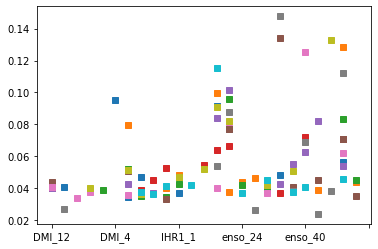

In [107]:
fimp_df.plot(legend=False,linestyle="None",marker='s')

<AxesSubplot:>

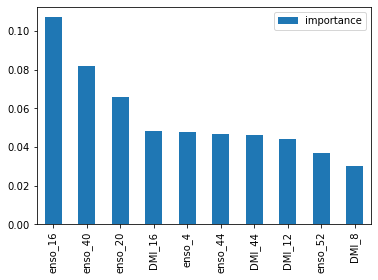

In [93]:
fimp.sort_values("importance",ascending=False).iloc[:10].plot(kind="bar")

In [94]:
fimp.sort_values("importance",ascending=False).iloc[:10]

,importance
enso_16,0.107212
enso_40,0.081851
enso_20,0.065745
DMI_16,0.048557
enso_4,0.047846
enso_44,0.046819
DMI_44,0.046178
DMI_12,0.044366
enso_52,0.037006
DMI_8,0.029956


,importance
enso_16,0.107212
enso_40,0.081851
enso_20,0.065745
DMI_16,0.048557
enso_4,0.047846
enso_44,0.046819
DMI_44,0.046178
DMI_12,0.044366
enso_52,0.037006
DMI_8,0.029956


0.523563
importance    0.145893
Name: IHR2_2, dtype: float32


<AxesSubplot:>

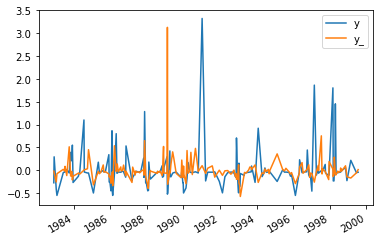

In [60]:
config['selected_features'] = fimp.sort_values("importance",ascending=False).iloc[:15].index.to_list()
rsl = run_once(data, config)
rmse = rsl[0]
fimp = rsl[1]
df_test = rsl[2]
print(rmse)
print(fimp.loc[fimp['importance'].idxmax()])
df_test.plot()

In [84]:
fimp

,importance
DMI,0.019448
enso,0.006704
IHR1,0.016097
IHR2,0.008534
month,0.007853
IHR1_1,0.093931
IHR1_2,0.027689
IHR1_3,0.054703
IHR1_4,0.046280
IHR2_1,0.012452


0.39355186
importance    0.117606
Name: enso_8, dtype: float32


<AxesSubplot:>

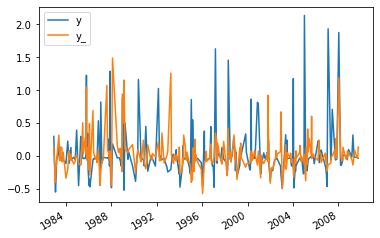

In [26]:
lat, lon = -19.5, 144.5
data = get_one_grid_ts(x2dmi, x1nino, tropical_AU, mjo, lat, lon)

config = {
    'val_start_date': '2010-01-01',
    'test_size': 0.2,
    'random_state': 123,
    'model_params':{
        #'max_depth':4
    }
}
rsl = run_once(data, config)
rmse = rsl[0]
fimp = rsl[1]
df_test = rsl[2]
print(rmse)
print(fimp.loc[fimp['importance'].idxmax()])
df_test.plot()

<AxesSubplot:>

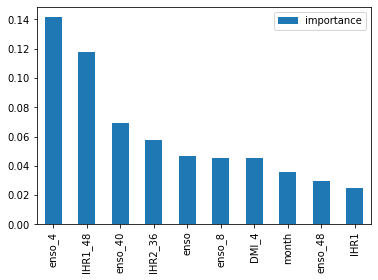

In [12]:
fimp.sort_values("importance",ascending=False).iloc[:10].plot(kind="bar")

# loop over grid points

In [13]:
len(fimp) # number of features

57

In [14]:
feature_dict = {x:i for i,x in enumerate(fimp.index.sort_values())}

rmse_array = np.empty((tropical_AU['lat'].shape[0], tropical_AU['lon'].shape[0]))
rmse_array[:] = np.NaN
ft_array = np.empty((tropical_AU['lat'].shape[0], tropical_AU['lon'].shape[0]))
ft_array[:] = np.NaN

for lat_i, lat  in enumerate(tropical_AU['lat']):
    for lon_i, lon in enumerate(tropical_AU['lon']):
        data = get_one_grid_ts(x2dmi, x1nino, tropical_AU, mjo, lat, lon)
        if data.dropna().shape[0] == 0:
            continue
        rsl = run_once(data, config)
        rmse = rsl[0]
        fimp = rsl[1]
        best_ft = fimp.loc[fimp['importance'].idxmax()].name
        ft_ind = feature_dict[best_ft]
        rmse_array[lat_i, lon_i] = rmse
        ft_array[lat_i, lon_i] = ft_ind



In [15]:
ft_xr = xr.DataArray(
    data=ft_array,
    dims=["lat", "lon"],
    coords=dict(
        lat=tropical_AU['lat'],
        lon=tropical_AU['lon'],
    )
)

rmse_xr = xr.DataArray(
    data=rmse_array,
    dims=["lat", "lon"],
    coords=dict(
        lat=tropical_AU['lat'],
        lon=tropical_AU['lon'],
    )
)

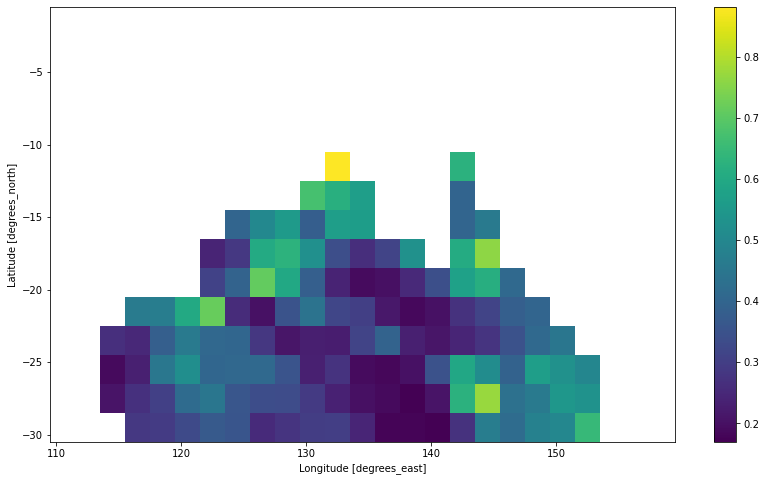

In [16]:
f, ax = plt.subplots(figsize=(14, 8))
rmse_xr.plot(ax=ax)
plt.show()

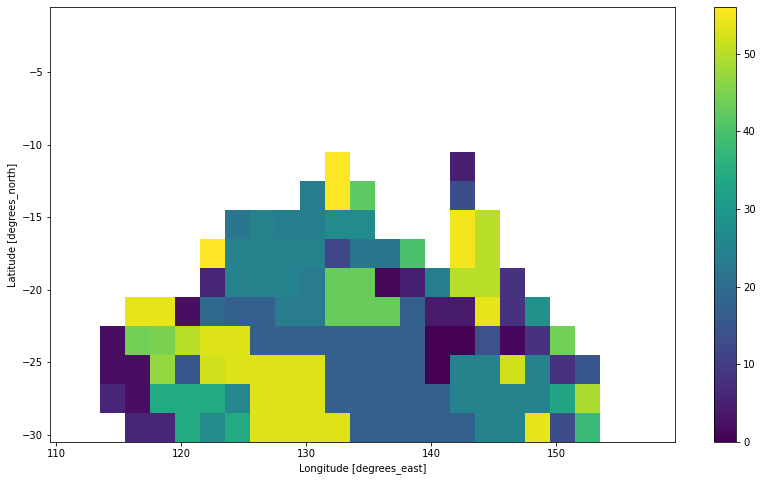

In [17]:
f, ax = plt.subplots(figsize=(14, 8))
ft_xr.plot(ax=ax)
plt.show()

# plot by factor

In [18]:
feature_dict_reverse = {v:k for k,v in feature_dict.items()}
ft_name = [[feature_dict_reverse[int(f)]  if ~np.isnan(f) else np.nan for f in x] for x in ft_array]
def contour_map(fig,img_extent,spec):
    fig.set_extent(img_extent, crs=ccrs.PlateCarree())
    fig.add_feature(cfeature.COASTLINE.with_scale('50m')) 
    fig.add_feature(cfeature.LAKES, alpha=0.5)
    fig.set_xticks(np.arange(leftlon,rightlon+spec,spec), crs=ccrs.PlateCarree())
    fig.set_yticks(np.arange(lowerlat,upperlat+spec,spec), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    fig.xaxis.set_major_formatter(lon_formatter)
    fig.yaxis.set_major_formatter(lat_formatter)

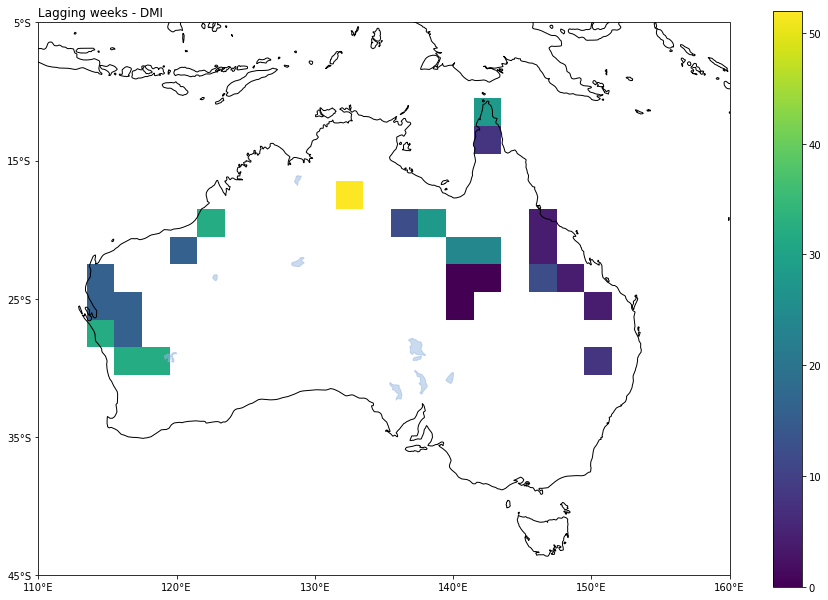

In [19]:
#DMI
dmi_name = []
for row in ft_name:
    new_row = []
    for val in row:
        new_val = np.nan
        if type(val)==str and val.startswith('DMI'):
            spl = val.split('_') 
            if len(spl) == 2:
                new_val = int(spl[1])
            else:
                new_val = 0
        new_row.append(new_val)
    dmi_name.append(new_row)

ft_xr = xr.DataArray(
    data=dmi_name,
    dims=["lat", "lon"],
    coords=dict(
        lat=tropical_AU['lat'],
        lon=tropical_AU['lon'],
    )
)

pre_lat = ft_xr['lat'].loc[-30:0]
pre_lon = ft_xr['lon']

## general settings
proj = ccrs.PlateCarree(central_longitude=130)
leftlon, rightlon, lowerlat, upperlat = (110,155,-45,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig2 = plt.figure(figsize=(12,8))


#subplot bottomleft
f2_ax1 = fig2.add_axes([0,0,1,1],projection = proj)
#
contour_map(f2_ax1,img_extent,10)
f2_ax1.set_title('Lagging weeks - DMI',loc='left')
CS=f2_ax1.pcolormesh(pre_lon,
                pre_lat, 
                ft_xr, 
                transform=ccrs.PlateCarree(),
                  )
cbar = fig2.colorbar(CS)


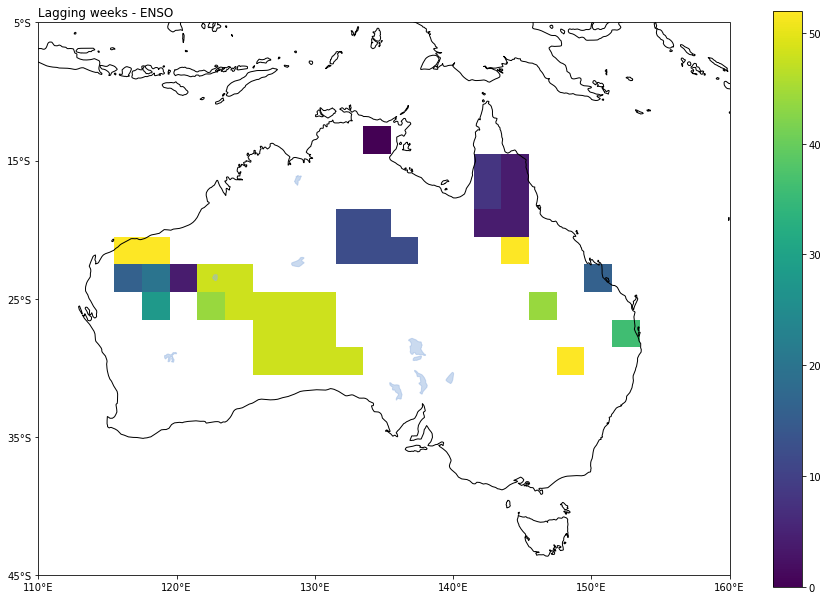

In [20]:
#enso
dmi_name = []
for row in ft_name:
    new_row = []
    for val in row:
        new_val = np.nan
        if type(val)==str and val.startswith('enso'):
            spl = val.split('_') 
            if len(spl) == 2:
                new_val = int(spl[1])
            else:
                new_val = 0
        new_row.append(new_val)
    dmi_name.append(new_row)

ft_xr = xr.DataArray(
    data=dmi_name,
    dims=["lat", "lon"],
    coords=dict(
        lat=tropical_AU['lat'],
        lon=tropical_AU['lon'],
    )
)

pre_lat = ft_xr['lat'].loc[-30:0]
pre_lon = ft_xr['lon']

## general settings
proj = ccrs.PlateCarree(central_longitude=130)
leftlon, rightlon, lowerlat, upperlat = (110,155,-45,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig2 = plt.figure(figsize=(12,8))


#subplot bottomleft
f2_ax1 = fig2.add_axes([0,0,1,1],projection = proj)
#
contour_map(f2_ax1,img_extent,10)
f2_ax1.set_title('Lagging weeks - ENSO',loc='left')
CS=f2_ax1.pcolormesh(pre_lon,
                pre_lat, 
                ft_xr, 
                transform=ccrs.PlateCarree(),
                  )
cbar = fig2.colorbar(CS)


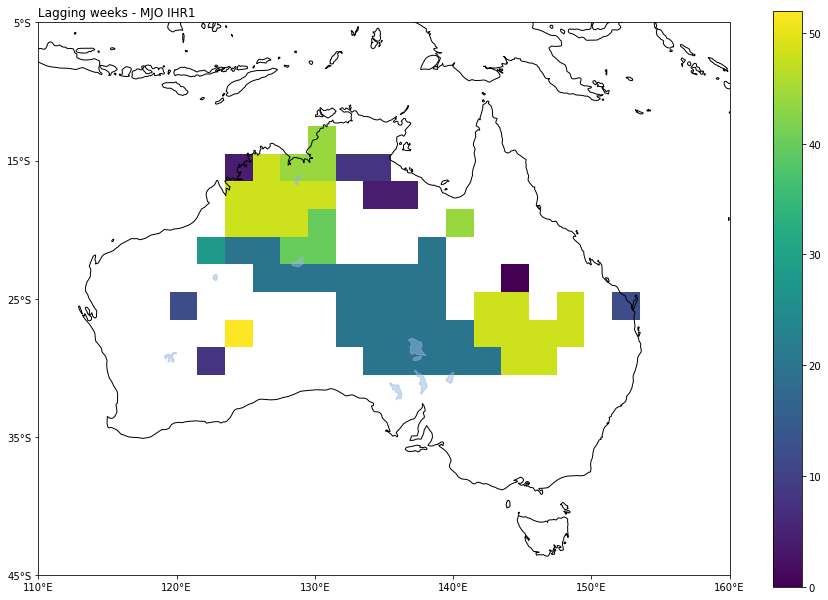

In [22]:
#phase
dmi_name = []
for row in ft_name:
    new_row = []
    for val in row:
        new_val = np.nan
        if type(val)==str and val.startswith('IHR1'):
            spl = val.split('_') 
            if len(spl) == 2:
                new_val = int(spl[1])
            else:
                new_val = 0
        new_row.append(new_val)
    dmi_name.append(new_row)

ft_xr = xr.DataArray(
    data=dmi_name,
    dims=["lat", "lon"],
    coords=dict(
        lat=tropical_AU['lat'],
        lon=tropical_AU['lon'],
    )
)

pre_lat = ft_xr['lat'].loc[-30:0]
pre_lon = ft_xr['lon']

## general settings
proj = ccrs.PlateCarree(central_longitude=130)
leftlon, rightlon, lowerlat, upperlat = (110,155,-45,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig2 = plt.figure(figsize=(12,8))


#subplot bottomleft
f2_ax1 = fig2.add_axes([0,0,1,1],projection = proj)
#
contour_map(f2_ax1,img_extent,10)
f2_ax1.set_title('Lagging weeks - MJO IHR1',loc='left')
CS=f2_ax1.pcolormesh(pre_lon,
                pre_lat, 
                ft_xr, 
                transform=ccrs.PlateCarree(),
                  )
cbar = fig2.colorbar(CS)



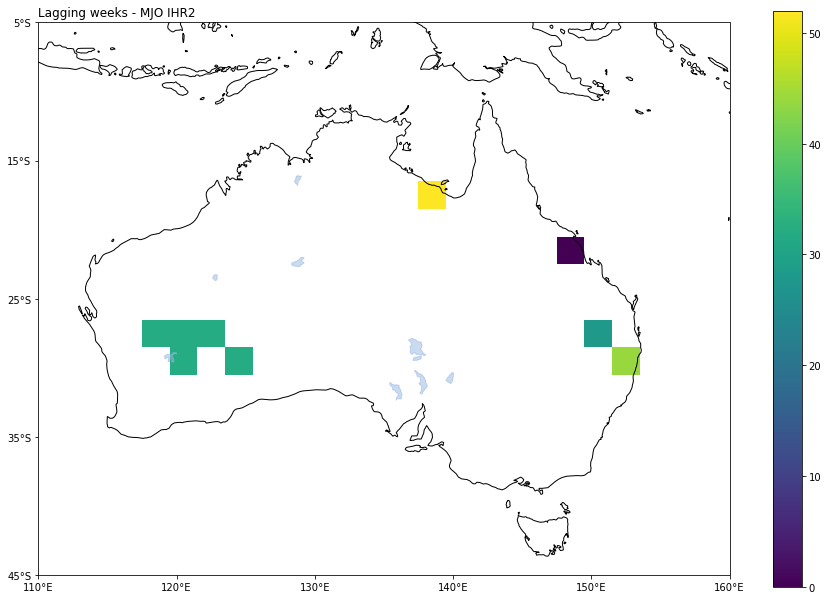

In [24]:
#phase
dmi_name = []
for row in ft_name:
    new_row = []
    for val in row:
        new_val = np.nan
        if type(val)==str and val.startswith('IHR2'):
            spl = val.split('_') 
            if len(spl) == 2:
                new_val = int(spl[1])
            else:
                new_val = 0
        new_row.append(new_val)
    dmi_name.append(new_row)

ft_xr = xr.DataArray(
    data=dmi_name,
    dims=["lat", "lon"],
    coords=dict(
        lat=tropical_AU['lat'],
        lon=tropical_AU['lon'],
    )
)

pre_lat = ft_xr['lat'].loc[-30:0]
pre_lon = ft_xr['lon']

## general settings
proj = ccrs.PlateCarree(central_longitude=130)
leftlon, rightlon, lowerlat, upperlat = (110,155,-45,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig2 = plt.figure(figsize=(12,8))


#subplot bottomleft
f2_ax1 = fig2.add_axes([0,0,1,1],projection = proj)
#
contour_map(f2_ax1,img_extent,10)
f2_ax1.set_title('Lagging weeks - MJO IHR2',loc='left')
CS=f2_ax1.pcolormesh(pre_lon,
                pre_lat, 
                ft_xr, 
                transform=ccrs.PlateCarree(),
                  )
cbar = fig2.colorbar(CS)


